# Meta-Feature evaluation

# Imports

In [1]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_paac, calculate_aac
from subpred.eval import (
    get_independent_test_set,
    optimize_hyperparams,
    preprocess_pandas,
    models_quick_compare,
    get_confusion_matrix,
    get_classification_report,
    full_test,
    quick_test,
    nested_loocv
)
from subpred.util import get_feature_score
from subpred.plots import labeled_clustermap, pca_plot_2d, pca_plot_3d
from subpred.pssm import calculate_pssms_notebook

import pandas as pd

# Dataset

In [2]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "integrate",
    verbose = True,
    tax_ids_filter = [9606],
    output_log = "../logs/human_amino_sugar_dataset.log",
    outliers=["Q9HBR0", "Q07837"],
    sequence_clustering=70
)

cd-hit: clustered 85 sequences into 81 clusters at threshold 70


# Feature generation

In [3]:
labels = df.keywords_transport
labels.value_counts()

Amino-acid transport    48
Sugar transport         33
Name: keywords_transport, dtype: int64

In [4]:
df_aac = calculate_aac(df.sequence)
df_paac = calculate_paac(df.sequence)
df_pssm = calculate_pssms_notebook(df.sequence)

In [5]:
df_combined = pd.concat([
    df_aac, df_paac, df_pssm
], axis=1)
df_combined

,A,C,D,E,F,G,H,I,K,L,...,VL_90_3,VK_90_3,VM_90_3,VF_90_3,VP_90_3,VS_90_3,VT_90_3,VW_90_3,VY_90_3,VV_90_3
Uniprot,,,,,,,,,,,,,,,,,,,,,
Q9BRV3,0.058824,0.022624,0.031674,0.018100,0.058824,0.072398,0.009050,0.045249,0.022624,0.176471,...,0.484375,0.403125,0.471875,0.706250,0.368750,0.443750,0.440625,0.568750,0.856250,0.478125
Q5M8T2,0.096154,0.024038,0.024038,0.050481,0.038462,0.093750,0.012019,0.052885,0.026442,0.129808,...,0.522388,0.492537,0.525373,0.659701,0.498507,0.516418,0.513433,0.594030,0.817910,0.498507
Q969S0,0.069486,0.018127,0.015106,0.033233,0.090634,0.060423,0.018127,0.090634,0.045317,0.126888,...,0.492669,0.398827,0.492669,0.568915,0.384164,0.422287,0.416422,0.609971,0.750733,0.472141
O75387,0.076923,0.026834,0.028623,0.035778,0.064401,0.078712,0.012522,0.046512,0.028623,0.148479,...,0.527546,0.510851,0.509182,0.602671,0.477462,0.514190,0.515860,0.544240,0.686144,0.512521
Q9NTN3,0.090141,0.011268,0.030986,0.039437,0.076056,0.076056,0.005634,0.061972,0.061972,0.129577,...,0.450704,0.357746,0.439437,0.645070,0.321127,0.388732,0.397183,0.594366,0.867606,0.450704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q96A29,0.082418,0.024725,0.024725,0.032967,0.054945,0.079670,0.008242,0.038462,0.038462,0.162088,...,0.547126,0.457471,0.531034,0.655172,0.427586,0.487356,0.482759,0.634483,0.749425,0.533333
Q9BYW1,0.098790,0.032258,0.012097,0.054435,0.048387,0.100806,0.010081,0.064516,0.018145,0.157258,...,0.534107,0.502177,0.528302,0.647315,0.489115,0.516691,0.513788,0.579100,0.718433,0.523948
P14672,0.086444,0.005894,0.011788,0.051081,0.053045,0.104126,0.007859,0.066798,0.015717,0.155206,...,0.514116,0.476969,0.505201,0.618128,0.471025,0.490342,0.484398,0.551263,0.716196,0.494799


## Plots

First, let's create a plot of the three feature types, and see how they look together in a dataframe:

({'aac': 'cyan', 'paac': 'magenta', 'pssm': 'yellow'},
 <seaborn.matrix.ClusterGrid at 0x7fbc88512d90>)

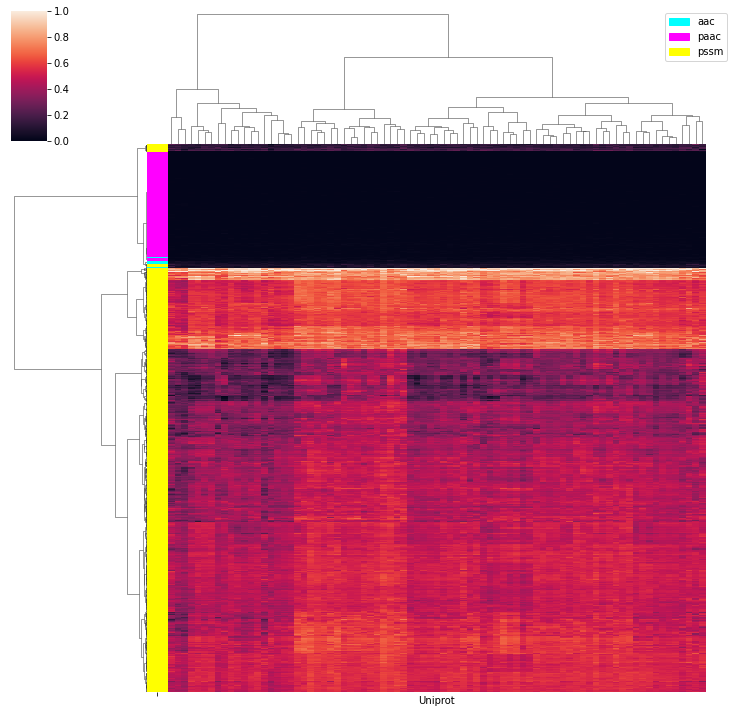

In [6]:
import re

aac = re.compile(r"^[ACDEFGHIKLMNPQRSTVWY]$")
paac = re.compile(r"^[ACDEFGHIKLMNPQRSTVWY][ACDEFGHIKLMNPQRSTVWY]$")
pssm = re.compile(r"^[ACDEFGHIKLMNPQRSTVWY][ACDEFGHIKLMNPQRSTVWY]_\d\d_\d$")

def get_feature_type(feature_name):
    if paac.match(feature_name):
        return "paac"
    elif aac.match(feature_name):
        return "aac"
    elif pssm.match(feature_name):
        return "pssm"
    else:
        raise ValueError("unknown feature type!")

labeled_clustermap(df_combined.T, df_combined.columns.to_series().apply(get_feature_type))

PAAC and AAC values are a lot lower, since they are percentages, while PSSM values are scaled to [0,1]. The scaling was done along the feature axis, to avoid information sharing. What does the data look like when we also scale PAAC and AAC to [0,1]?

({'aac': 'cyan', 'paac': 'magenta', 'pssm': 'yellow'},
 <seaborn.matrix.ClusterGrid at 0x7fb9b1e6f7f0>)

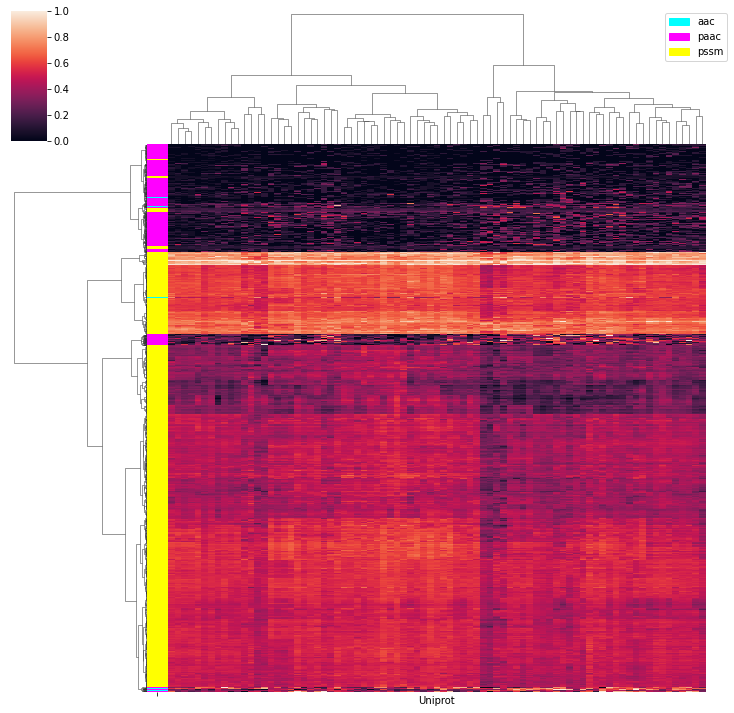

In [7]:
from sklearn.preprocessing import minmax_scale

def min_max_samples(df_feature):
    return pd.DataFrame(data=minmax_scale(df_feature, axis=1), index=df_feature.index, columns = df_feature.columns)

df_combined_minmax = pd.concat([
    min_max_samples(df_aac), min_max_samples(df_paac), min_max_samples(df_pssm)
], axis=1)
# df_combined_minmax = pd.DataFrame(data=minmax_scale(df_combined, axis=1), index=df_combined.index, columns = df_combined.columns)
labeled_clustermap(df_combined_minmax.T, df_combined_minmax.columns.to_series().apply(get_feature_type))
# df_combined_minmax#.iloc[0].max()

The PCA plot looks similar to E coli, in terms of  shape. Some PSSM features are closer to paac, because they have a low frequency. That can be observed in the heatmap above.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

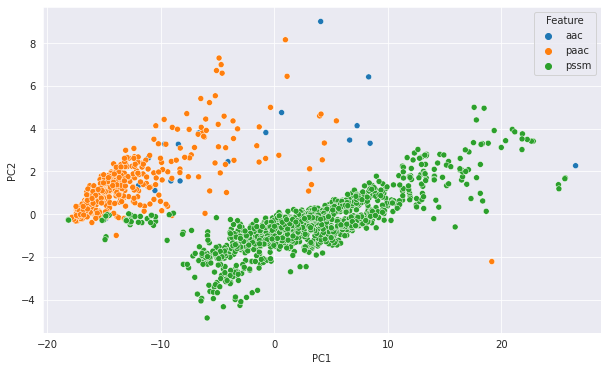

In [8]:
pca_plot_2d(df_combined_minmax.T, df_combined_minmax.T.index.to_series().apply(get_feature_type).rename("Feature"))

What does the data look like when standardizing along the feature axis? In the model, the parameters for this will be derived from the training set and applied to the test set, to avoid data leakage.

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7fb9b815cd60>)

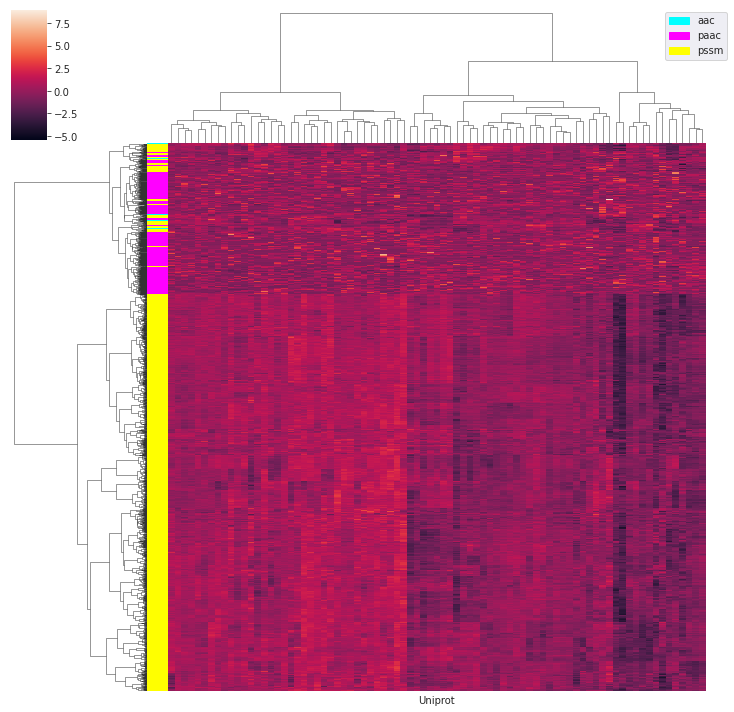

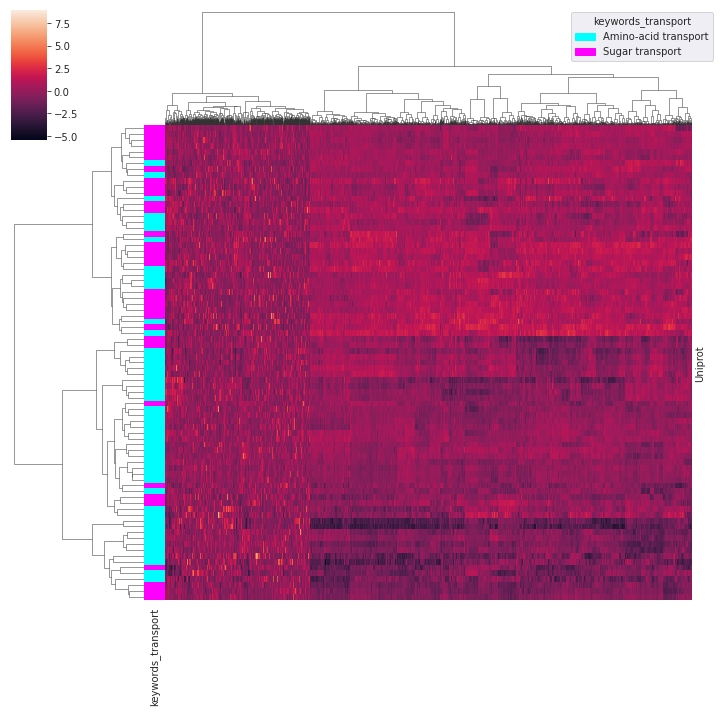

In [9]:
from sklearn.preprocessing import scale

df_combined_std = pd.DataFrame(
    data=scale(df_combined), index=df_combined.index, columns=df_combined.columns
)
labeled_clustermap(
    df_combined_std.T, df_combined.columns.to_series().apply(get_feature_type)
)
labeled_clustermap(
    df_combined_std, df.keywords_transport
)

The composition data looks a bit noisier, however this could also be caused by the fact that more PSSM features exist, and therefore have a higher impact on the h-clustering algorithm. The second plot shows that the two sample clusters do not correspond to the classes. 

The PCA plot of the standardized features also looks good. There is a separation between most PSSM features and the rest of the dataset, possibly because of their lower variance

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

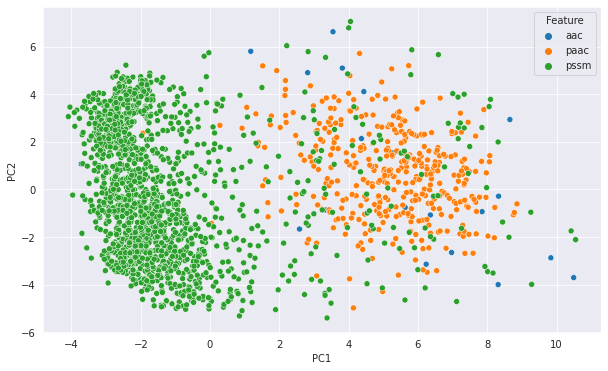

In [10]:
pca_plot_2d(df_combined_std.T, df_combined_std.T.index.to_series().apply(get_feature_type).rename("Feature"))

## Independent test set

In [11]:
X, y, feature_names, sample_names = preprocess_pandas(
    df_combined, labels, return_names=True
)
(
    X_train,
    X_test,
    y_train,
    y_test,
    sample_names_train,
    sample_names_test,
) = get_independent_test_set(X, y, sample_names=sample_names, test_size=0.2)



## Model comparison

In [12]:
models_quick_compare(X_train, y_train)

,0,1,2,3,4,mean,std
est,,,,,,,
GaussianNB(),0.845,0.513,0.639,0.606,0.833,0.687,0.146
KNeighborsClassifier(),0.915,0.575,0.707,0.606,0.916,0.744,0.164
"LinearSVC(class_weight='balanced', max_iter=1000000.0, random_state=0)",0.845,0.764,0.915,0.690,0.829,0.809,0.085
"LinearSVC(max_iter=1000000.0, random_state=0)",0.845,0.764,0.915,0.690,0.829,0.809,0.085
"RandomForestClassifier(class_weight='balanced', random_state=0)",0.921,0.675,0.567,0.690,0.833,0.737,0.140
RandomForestClassifier(random_state=0),0.764,0.675,0.567,0.769,0.916,0.738,0.129
SGDClassifier(random_state=0),0.921,0.606,0.707,0.512,0.916,0.733,0.183
"SVC(class_weight='balanced', random_state=0)",0.921,0.606,0.567,0.690,0.916,0.740,0.169
SVC(random_state=0),0.745,0.675,0.381,0.690,1.000,0.698,0.221


Again, the linear SVM model looks good. The large number of features could lead to overfitting.

## Feature importance

How many top 50 features come from each feature type?

In [13]:
top50 = get_feature_score(df_combined, labels, remove_zero_variance=True).sort_values(
    "Normalized score", ascending=False
).head(50)
top50.Feature.apply(get_feature_type).value_counts()

pssm    50
Name: Feature, dtype: int64

As in E Coli, all of the top 50 features according to ANOVA come from the PSSM feature.

In [14]:
top50[top50.Feature.apply(get_feature_type) == "pssm"].head(10)


,Feature,Normalized score,Measure
1072,MM_50_3,0.003158,Feature importance (f_classif)
674,MP_50_1,0.003124,Feature importance (f_classif)
1865,MQ_90_3,0.002844,Feature importance (f_classif)
1000,IA_50_3,0.002768,Feature importance (f_classif)
1074,MP_50_3,0.002723,Feature importance (f_classif)
1007,IG_50_3,0.002645,Feature importance (f_classif)
1065,MQ_50_3,0.002628,Feature importance (f_classif)
1069,MI_50_3,0.002558,Feature importance (f_classif)
832,AM_50_3,0.002493,Feature importance (f_classif)
1862,MN_90_3,0.002432,Feature importance (f_classif)


There seems to be a significant number of Methionine dipeptides among the top 50 features:

In [15]:
top50[top50.Feature.apply(get_feature_type) == "pssm"].Feature.apply(lambda x: [x[0], x[1]]).explode().value_counts()

M    36
I     8
A     8
G     6
N     6
L     5
V     5
R     4
E     4
Q     3
P     3
S     3
W     3
F     2
K     2
D     1
T     1
Name: Feature, dtype: int64

Methionine could be the hydrogen bond donor that leads to the selectivity for either amino-acid or sugar in a considerable number of transporters since its conservation, which is encoded through the PSSM, is be a good measure for training the classifier. 

## Parameter tuning

#### Custom transformer


Whole dataset, linear svm

In [16]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="linear",
    dim_reduction=None,
    C=[0.1, 1, 10],
)
best_estimator_svc = gsearch


{'linearsvc__C': 1, 'linearsvc__class_weight': 'balanced', 'linearsvc__dual': False, 'linearsvc__max_iter': 100000000.0}
0.841


Good results, but relatively high value for C. With the custom transformer:

In [17]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="linear",
    dim_reduction=None,
    C=[0.1, 1, 10],
    feature_transformer="pssm",
    feature_names=feature_names,
)
best_estimator_svc = gsearch


{'linearsvc__C': 10, 'linearsvc__class_weight': 'balanced', 'linearsvc__dual': False, 'linearsvc__max_iter': 100000000.0, 'pssmselector__iterations': 'all', 'pssmselector__uniref_threshold': 50}
0.874


The scores are actually slightly better than with just the PSSM feature, when using a linear kernel. What about RBF?

In [18]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction=None,
    C=[1, 10, 100],
)

{'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.748


In [19]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction=None,
    C=[0.1, 1, 10],
    feature_transformer="pssm",
    feature_names=feature_names,
)

{'pssmselector__iterations': 3, 'pssmselector__uniref_threshold': 50, 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.863


The fit is worse with just RBF, but the pssmselector helps a bit.

## Dimensionality reduction

Trying only in steps of 20, to reduce runtime.

In [20]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="linear",
    dim_reduction="kbest",
    C=[1, 10, 100],
    select_k_steps=20,
    remove_zero_var=True,
)
best_estimator_lsvc_kbest = gsearch


{'linearsvc__C': 10, 'linearsvc__class_weight': 'balanced', 'linearsvc__dual': False, 'linearsvc__max_iter': 100000000.0, 'selectkbest__k': 1761}
0.874


Feature selection does not improve the linear kernel, the same with PCA:

In [21]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="linear",
    dim_reduction="pca",
    # feature_transformer="pssm",
    # feature_names=feature_names,
    C=[0.1, 0.01, 0.001],
    # gamma=[0.1, 0.01, 0.001],
)


{'linearsvc__C': 0.1, 'linearsvc__class_weight': 'balanced', 'linearsvc__dual': True, 'linearsvc__max_iter': 100000000.0, 'pca__n_components': 0.99}
0.858


Does using the RBF kernel change anything?

In [22]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction="pca",
    # feature_transformer="pssm",
    # feature_names=feature_names,
    C=[1, 10,100],
    gamma=["scale"],
)

{'pca__n_components': 0.98, 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
0.867


The RBF+PCA model with the pssmselector gives the best model:

In [23]:
gsearch = optimize_hyperparams(
    X_train,
    y_train,
    kernel="rbf",
    dim_reduction="pca",
    feature_transformer="pssm",
    feature_names=feature_names,
    C=[1, 10, 100],
    # gamma=["scale", 0.1, 0.01, 0.001],
)
best_estimator_svc_pca = gsearch

{'pca__n_components': 0.8300000000000001, 'pssmselector__iterations': 3, 'pssmselector__uniref_threshold': 'all', 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__gamma': 0.1}
0.903


## Validation

For our independent test set, the Kbest score is perfect, while the PCA has one wrong classification.

### Kbest

In [24]:
get_confusion_matrix(X_test, y_test, best_estimator_lsvc_kbest, labels=labels)

predicted,Amino-acid transport,Sugar transport
observed,,
Amino-acid transport,10,0
Sugar transport,0,7


In [25]:
get_classification_report(X_test, y_test, best_estimator_lsvc_kbest, labels=labels)

,precision,recall,f1-score,support
Amino-acid transport,1.0,1.0,1.0,10
Sugar transport,1.0,1.0,1.0,7
macro avg,1.0,1.0,1.0,17
weighted avg,1.0,1.0,1.0,17


### PCA

In [26]:
get_confusion_matrix(X_test, y_test, best_estimator_svc_pca, labels=labels)

predicted,Amino-acid transport,Sugar transport
observed,,
Amino-acid transport,10,0
Sugar transport,1,6


In [27]:
get_classification_report(X_test, y_test, best_estimator_svc_pca, labels=labels)

,precision,recall,f1-score,support
Amino-acid transport,0.909,1.000,0.952,10
Sugar transport,1.000,0.857,0.923,7
macro avg,0.955,0.929,0.938,17
weighted avg,0.947,0.941,0.940,17


## Alternative evaluation with nested LOOCV

In [28]:
nested_loocv(df_features=df_combined, labels=labels, dim_reduction=None, kernel="rbf", feature_transformer="pssm")

,train,test
F1 (macro),0.901,0.859


In [29]:
nested_loocv(df_features=df_combined, labels=labels, dim_reduction="pca", kernel="rbf", feature_transformer="pssm")

,train,test
F1 (macro),0.955,0.857


## Estimating validation variance

How much did the result depend on choosing the training and test sets?

Mean and standard deviation for randomly selected training and validation sets.

In [30]:
df_scores, df_params = full_test(
    df_combined,
    labels,
    dim_reduction="pca",
    kernel="rbf",
    repetitions=10,
    feature_transformer="pssm",
)
df_scores_gr = df_scores.groupby(["label", "dataset"], as_index=False)
print("Mean F1")
display(df_scores_gr.mean().pivot(index="label", columns="dataset", values="F1 score"))
print("Sdev F1")
display(df_scores_gr.std().pivot(index="label", columns="dataset", values="F1 score"))
print("Parameters")
display(df_params)

Mean F1


dataset,test,train
label,,
Amino-acid transport,0.8582,0.9285
Sugar transport,0.7802,0.8968


Sdev F1


dataset,test,train
label,,
Amino-acid transport,0.077646,0.03016
Sugar transport,0.125405,0.04557


Parameters


,0,1,2,3,4,5,6,7,8,9
pca__n_components,0.98,0.87,0.88,0.93,0.82,0.96,0.97,0.98,0.96,0.81
pssmselector__iterations,3,3,all,1,all,1,all,all,3,3
pssmselector__uniref_threshold,50,all,all,all,all,all,50,all,50,all
svc__C,1,10,1,10,1,1,1,1,10,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__gamma,scale,0.01,0.1,scale,0.1,scale,scale,scale,0.01,0.01


Similar to the other features, the indepentent test set of sugar transporter shows the lowest performance, possibly due to low sample count, while the overall model fit during the cross validation seems to be good.

However, the PSSM feature alone performed slightly better with PCA and RBF. The results for the linear kernel are very similar:

In [31]:
df_scores, df_params = full_test(
    df_combined,
    labels,
    # dim_reduction="pca",
    kernel="linear",
    repetitions=10,
    feature_transformer="pssm",
)
df_scores_gr = df_scores.groupby(["label", "dataset"], as_index=False)
print("Mean F1")
display(df_scores_gr.mean().pivot(index="label", columns="dataset", values="F1 score"))
print("Sdev F1")
display(df_scores_gr.std().pivot(index="label", columns="dataset", values="F1 score"))
print("Parameters")
display(df_params)

Mean F1


dataset,test,train
label,,
Amino-acid transport,0.8615,0.8983
Sugar transport,0.8086,0.8698


Sdev F1


dataset,test,train
label,,
Amino-acid transport,0.072489,0.020194
Sugar transport,0.118819,0.021431


Parameters


,0,1,2,3,4,5,6,7,8,9
linearsvc__C,1,10,1,1,10,10,10,1,1,10
linearsvc__class_weight,balanced,balanced,balanced,balanced,None,balanced,balanced,balanced,balanced,balanced
linearsvc__dual,False,False,True,False,False,False,False,False,False,False
linearsvc__max_iter,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0
pssmselector__iterations,3,3,1,1,1,all,1,all,all,1
pssmselector__uniref_threshold,all,50,50,50,all,50,50,50,50,all


### LOOCV

Does the low number of samples lead to better F1 scores when using LOOCV instead of 5-fold stratified cross validation?

In [32]:
df_scores, df_params = full_test(
    df_combined,
    labels,
    # dim_reduction="pca",
    kernel="linear",
    cross_val_method="loocv",
    repetitions=10,
    feature_transformer="pssm",
)
df_scores_gr = df_scores.groupby(["label", "dataset"], as_index=False)
print("Mean F1")
display(df_scores_gr.mean().pivot(index="label", columns="dataset", values="F1 score"))
print("Sdev F1")
display(df_scores_gr.std().pivot(index="label", columns="dataset", values="F1 score"))
print("Parameters")
display(df_params)

Mean F1


dataset,test,train
label,,
Amino-acid transport,0.8692,0.9192
Sugar transport,0.8263,0.8930


Sdev F1


dataset,test,train
label,,
Amino-acid transport,0.074702,0.017364
Sugar transport,0.096215,0.023893


Parameters


,0,1,2,3,4,5,6,7,8,9
linearsvc__C,1,1,1,10,1,1,1,1,10,1
linearsvc__class_weight,balanced,balanced,balanced,None,balanced,balanced,balanced,balanced,None,balanced
linearsvc__dual,True,True,True,False,False,True,True,True,False,False
linearsvc__max_iter,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0
pssmselector__iterations,3,3,1,1,3,all,all,1,all,3
pssmselector__uniref_threshold,50,50,all,50,50,50,50,all,50,50


Yes, it actually improves the average score by a few points!

### Effect of removing Sideroflexins

Removing these proteins, which appeared as outliers in the PCA in notebooks 1-2, improved the F1 scores for the PAAC feature, but not for AAC and PSSM. How about the combined feature with the linear SVM?

In [33]:
mask_sideroflexin = ~df.protein_names.str.startswith("Side")
df_scores, df_params = full_test(
    df_combined.loc[mask_sideroflexin],
    labels.loc[mask_sideroflexin],
    # dim_reduction="pca",
    kernel="linear",
    repetitions=10,
    feature_transformer="pssm",
    # cross_val_method="loocv",
)
display(
    df_scores.groupby(["label", "dataset"], as_index=False)
    .mean()
    .pivot(index="label", columns="dataset", values="F1 score")
)
display(
    df_scores.groupby(["label", "dataset"], as_index=False)
    .std()
    .pivot(index="label", columns="dataset", values="F1 score")
)
df_params


dataset,test,train
label,,
Amino-acid transport,0.8975,0.8779
Sugar transport,0.8683,0.8541


dataset,test,train
label,,
Amino-acid transport,0.064842,0.024251
Sugar transport,0.094185,0.032009


,0,1,2,3,4,5,6,7,8,9
linearsvc__C,10,1,1,10,1,10,1,0.1,1,0.1
linearsvc__class_weight,balanced,balanced,balanced,None,balanced,None,balanced,balanced,balanced,balanced
linearsvc__dual,False,True,False,False,True,False,True,True,False,True
linearsvc__max_iter,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0
pssmselector__iterations,1,1,1,1,1,1,1,all,1,all
pssmselector__uniref_threshold,50,all,all,50,all,all,50,50,50,50


That seems to make the model a bit more stable, with lower average standard deviations and closer scores for training set and test set. LOOCV improves the training cv scores a bit:

In [34]:
mask_sideroflexin = ~df.protein_names.str.startswith("Side")
df_scores, df_params = full_test(
    df_combined.loc[mask_sideroflexin],
    labels.loc[mask_sideroflexin],
    # dim_reduction="pca",
    kernel="linear",
    repetitions=10,
    feature_transformer="pssm",
    cross_val_method="loocv",
)
display(
    df_scores.groupby(["label", "dataset"], as_index=False)
    .mean()
    .pivot(index="label", columns="dataset", values="F1 score")
)
display(
    df_scores.groupby(["label", "dataset"], as_index=False)
    .std()
    .pivot(index="label", columns="dataset", values="F1 score")
)
df_params


dataset,test,train
label,,
Amino-acid transport,0.8792,0.9109
Sugar transport,0.8492,0.8941


dataset,test,train
label,,
Amino-acid transport,0.050104,0.029730
Sugar transport,0.077753,0.033205


,0,1,2,3,4,5,6,7,8,9
linearsvc__C,1,10,1,10,1,10,1,1,1,1
linearsvc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
linearsvc__dual,True,False,False,False,True,False,True,True,True,True
linearsvc__max_iter,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0,100000000.0
pssmselector__iterations,1,1,all,3,all,1,3,1,1,3
pssmselector__uniref_threshold,50,90,50,50,50,50,50,all,50,all
